# Main analysis

In [1]:
%load_ext autoreload
%load_ext skip_kernel_extension
%autoreload 2

### Imports

In [2]:
# External packages
import logging
import os
import jupyter_slack
import datetime

# Internal modules
from logger import logger
from constants import *
from utils import *
from fileops import *
from postpro import *
from plotters import *
from batchutils import *

# Figures dictionary
figs = {}

### Input datasets and main processing parameters

In [3]:
analysis_type = 'main' # DEFAULT_ANALYSIS  # Analysis type
layer = None  # cortical layer
slack_notify = False
kalman_gain = KALMAN_GAIN  # Gain of Kalman filter
neuropil_scaling_coeff = NEUROPIL_SCALING_COEFF  # scaling coefficient for neuropil subtraction
baseline_quantile = BASELINE_QUANTILE  # evaluation quantile for baseline computation
baseline_wquantile = BASELINE_WQUANTILE  # quantile filter window size (s) to compute fluorescence baseline
baseline_wsmoothing = BASELINE_WSMOOTHING  # gaussian filter window size (s) to smooth out fluorescence baseline
trial_aggfunc = TRIAL_AGGFUNC  # trial aggregation function
ykey_classification = YKEY_CLASSIFICATION  # Reference variable for response classification
directional = DIRECTIONAL_DETECTION  # whether to look for directional (i.e. positive only) effect for response detection
errprop = 'inter'
xkeys_plt = [  # Input parameters
    Label.P, 
    Label.DC,
    Label.ISPTA
]

### Derived parameters

In [4]:
# Get batch-related settings
_, input_dir, figsdir, figs_suffix = get_batch_settings(
    analysis_type, None, layer, kalman_gain, neuropil_scaling_coeff,
    baseline_quantile, baseline_wquantile, baseline_wsmoothing,
    trial_aggfunc, ykey_classification, directional)
baseline_quantile_str = 'adaptive' if baseline_quantile is None else f'{baseline_quantile:.2f}'
figs_suffix = f'{figs_suffix}_{errprop}'

# Get time stamp from notebook start
tstamp_start = datetime.datetime.now()
fmts = ['%Y-%m-%d', '%H:%M:%S']
# Log start process
s = f'{analysis_type} analysis notebook started on {tstamp_start.strftime(fmts[0])} at {tstamp_start.strftime(fmts[1])}'
if slack_notify:
    jupyter_slack.notify_self(s)
logger.info(s)

 11/07/2023 12:44:48: assembling batch analysis settings...
 11/07/2023 12:44:48: main analysis notebook started on 2023-07-11 at 12:44:48


### Input summary table figure

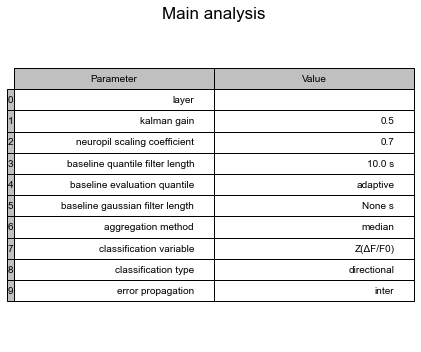

In [5]:
figs['dataset_info'] = plot_table({
    'layer': layer,
    'kalman gain': kalman_gain,
    'neuropil scaling coefficient': neuropil_scaling_coeff,
    'baseline quantile filter length': f'{baseline_wquantile} s',
    'baseline evaluation quantile': baseline_quantile_str,
    'baseline gaussian filter length': f'{baseline_wsmoothing} s',
    'aggregation method': trial_aggfunc.__name__,
    'classification variable': ykey_classification,
    'classification type': f"{'' if directional else 'non '}directional",
    'error propagation': errprop,
    }, title='Main analysis', aspect=1.5)

### Load data

In [6]:
stats = load_lineagg_stats(input_dir, errprop=errprop)
# Remove PV
if 'pv' in stats.index.unique(Label.LINE):
    stats = stats.drop(labels='pv')
isall = stats.index.get_level_values(Label.ROI_RESP_TYPE) == 'all'
stats_all = stats[isall].droplevel(Label.ROI_RESP_TYPE)
stats_by_rtype = stats[~isall]
stats_pos = stats_by_rtype.loc[pd.IndexSlice[:, 'positive', :]]

 11/07/2023 12:44:48: loading line-average data (with inter-propagated SE) from /Users/tlemaire/Documents/data/usnm/lineagg/aggmedian_classzscore_directional/alpha0.7_qadaptive_wq10.0s/suite2p_fs_3.56_reg_tif_tau_1.25/kd_G0.5_V0.05_npad10/submap_0<-1_9->10every100/main:
 11/07/2023 12:44:48: repsonder-type-averaged stats successfully loaded for lines line3, pv, sst


### Plot responder type distribution per mouse line

In [7]:
stats.columns

Index(['trial_length', 'PRF (Hz)', 'duration (s)', 'fps', 'P (MPa)', 'DC (%)',
       'I_SPPA (W/cm2)', 'I_SPTA (W/cm2)', 'pre-stimulus outlier?', 'count',
       'mean pre-stim Z(ΔF/F0) - mean', 'mean pre-stim Z(ΔF/F0) - sem',
       'peak displacement velocity (um/s) - mean',
       'peak displacement velocity (um/s) - sem', 'evoked ΔF/F0 change - mean',
       'evoked ΔF/F0 change - sem',
       'average displacement velocity (um/s) - mean',
       'average displacement velocity (um/s) - sem', 'positive - mean',
       'positive - sem', 'evoked Z(ΔF/F0) change - mean',
       'evoked Z(ΔF/F0) change - sem', 'weak - mean', 'weak - sem',
       'responder fraction - mean', 'responder fraction - sem'],
      dtype='object')

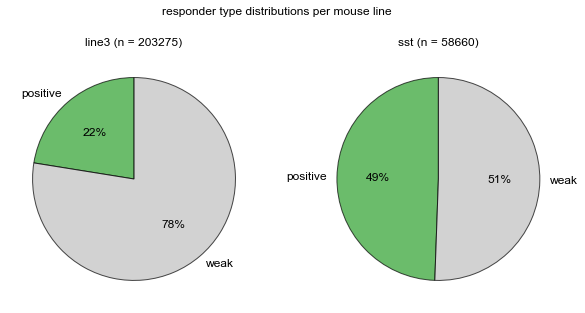

In [8]:
# Plot counts on pie chart
groups = stats_by_rtype.groupby(Label.LINE)
naxes = len(groups)
figs['rtype_dist_per_line'], axes = plt.subplots(1, naxes, figsize=(5 * naxes, 5))
figs['rtype_dist_per_line'].set_facecolor('w')
figs['rtype_dist_per_line'].suptitle('responder type distributions per mouse line')
for ax, (line, gdata) in zip(axes, groups):
    counts_by_rtype = gdata['count'].groupby(Label.ROI_RESP_TYPE).first()
    ax.set_title(f'{line} (n = {counts_by_rtype.sum()})')
    counts_by_rtype.plot.pie(
        ax=ax, ylabel='', autopct='%1.0f%%',
        colors=[Palette.RTYPE[k] for k in counts_by_rtype.index],
        startangle=90, textprops={'fontsize': 12},
        wedgeprops={'edgecolor': 'k', 'alpha': 0.7}
    )

### Plot parameter dependency curves 

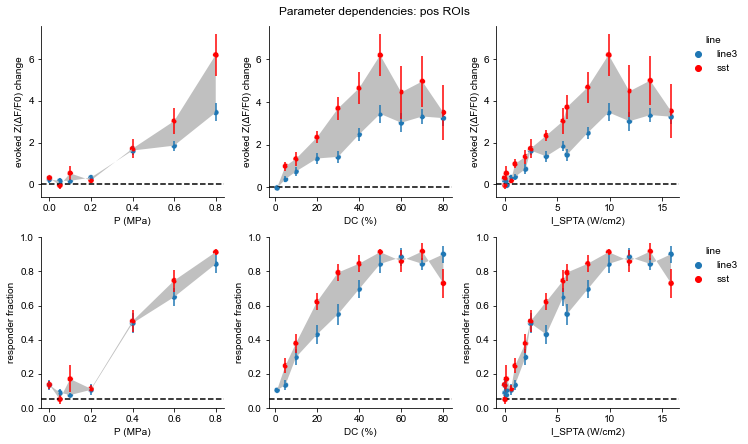

In [9]:
ykeys = [get_change_key(Label.ZSCORE), Label.RESP_FRAC]
for statstype, tmpstats in {
        # 'all': stats_all, 
        'pos': stats_pos
    }.items():
    figs[f'simparams_deps_{statstype}'], axes = plt.subplots(
        len(ykeys), len(xkeys_plt), figsize=(3.5 * len(xkeys_plt), 3 * len(ykeys)))
    for ykey, axrow in zip(ykeys, axes):
        plot_parameter_dependency_across_lines(
            tmpstats.copy(),
            xkeys_plt,
            ykey,
            yref=PTHR_DETECTION if ykey == Label.RESP_FRAC else 0.,
            axes=axrow,
            connect=None,
            err_style='bars',
            fill_between=True,
            # norm=True
        )
    figs[f'simparams_deps_{statstype}'].suptitle(
        f'Parameter dependencies: {statstype} ROIs', y=1.02)
    harmonize_axes_limits(axrow)
    if ykey == Label.RESP_FRAC:
        for ax in axrow:
            ax.set_ylim(0, 1)

### Fit response strength = f(ISPTA)

 11/07/2023 12:44:49: normalizing evoked Z(ΔF/F0) change to range [-0.0367, 3.44]
 11/07/2023 12:44:49: best evoked Z(ΔF/F0) change fit = sigmoid(P_SPTA (MPa), 0.22, 0.09, 0.98): R2 = 0.97
 11/07/2023 12:44:49: normalizing evoked Z(ΔF/F0) change to range [-0.0367, 3.44]
 11/07/2023 12:44:49: best evoked Z(ΔF/F0) change fit = sigmoid(I_SPTA (W/cm2), 5.54, 2.20, 0.98): R2 = 0.97
 11/07/2023 12:44:49: normalizing evoked Z(ΔF/F0) change to range [-0.0367, 3.44]
 11/07/2023 12:44:49: best evoked Z(ΔF/F0) change fit = sigmoid(P_SPTRMS (MPa), 0.30, 0.08, 1.06): R2 = 0.96
 11/07/2023 12:44:49: normalizing evoked Z(ΔF/F0) change to range [-0.0367, 3.44]
 11/07/2023 12:44:49: best evoked Z(ΔF/F0) change fit = sigmoid(I_SPTRMS (W/cm2), 9.12, 2.30, 1.06): R2 = 0.96
 11/07/2023 12:44:49: normalizing evoked Z(ΔF/F0) change to range [-0.0445, 6.19]
 11/07/2023 12:44:49: best evoked Z(ΔF/F0) change fit = sigmoid(P_SPTA (MPa), 0.15, 0.06, 0.77): R2 = 0.87
 11/07/2023 12:44:49: normalizing evoked Z(ΔF/F

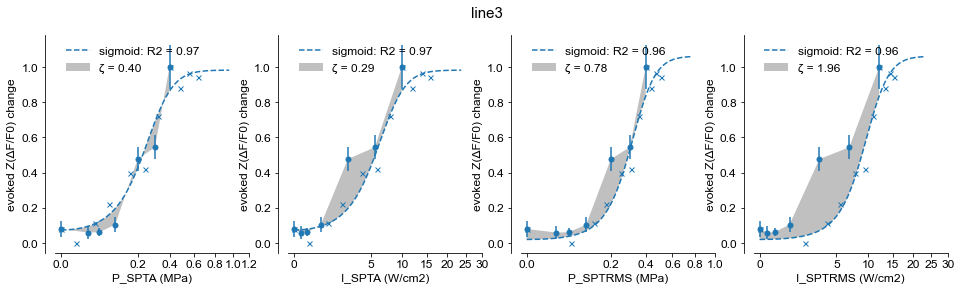

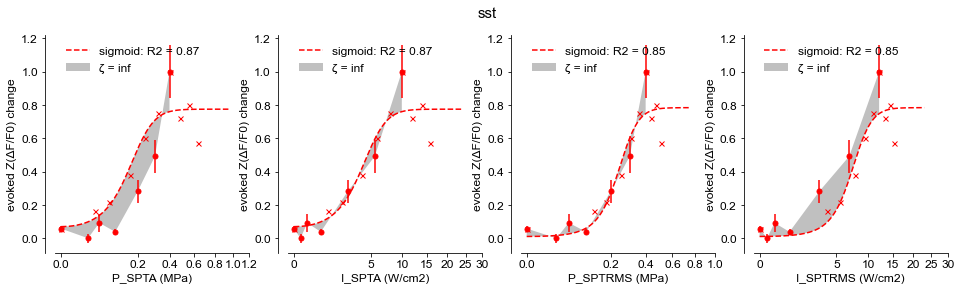

In [10]:
# Independent variables used for fits
fit_xkeys = [
    # Label.P,
    # Label.DC,
    Label.PSPTA, 
    Label.ISPTA, 
    Label.PSPTRMS, 
    Label.ISPTRMS
]

# Dependent variables used for fits
fit_ykeys = [
    get_change_key(Label.ZSCORE)
]

# Candidate fitting functions to predict response strength
fit_candidates = {
    sigmoid: lambda x, y: [x.mean(), np.ptp(x) / 2, y.max()],
    # custom_sigmoid: [1, 1, 1, 1],
    # mysqrt: lambda x, y: [y.max()], #.1],
    # parabolic: lambda x, y: [np.quantile(x, .1), np.quantile(x, .9), y.max() * 10],
    # bilinear: lambda x, y: [x[np.argmax(y)], y.max(), 1, -1],
}

# For each line
for line, gstats in stats_pos.groupby(Label.LINE):
    # For each output metrics
    for ykey_diff in fit_ykeys:
        # Find optimal fits to predict response strength, and plot results
        figs[f'{line} {ykey_diff} fits'], _ = plot_response_fit(
            gstats, ykey_diff, fit_candidates, 
            xkey=fit_xkeys, 
            xscale='sqrt', 
            fitsweepkey=Label.DC,
            error_aggfunc='mean',
            height=4,
            norm=True,
            # plot_respmetrics=True,
        )

 11/07/2023 12:44:50: best evoked ΔF/F0 change fit = sigmoid(I_SPTA (W/cm2), 5.38, 2.39, 0.02): R2 = 0.92
 11/07/2023 12:44:50: best evoked ΔF/F0 change fit = sigmoid(I_SPTA (W/cm2), 3.71, 1.49, 0.05): R2 = 0.79


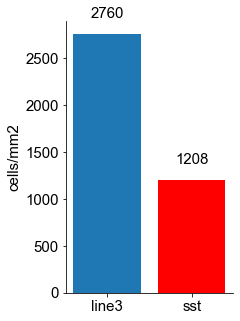

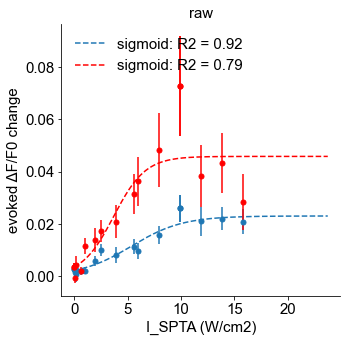

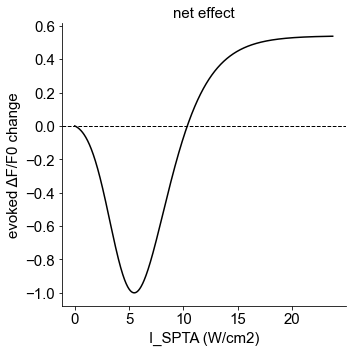

In [11]:
def plot_net_effect(d, xkey, ykey, title=None, ax=None, fs=15, factors=None):
    '''
    Plot net effect of line3-sst populatios interactions on circuit activity
    
    :param xkey: name of independent variable (e.g., ISPTA)
    :param ykey: name of dependent variable (e.g., z-score change)
    :param title (optional): title of plot
    :param ax (optional): axis to plot on
    :param fs (optional): font size
    :param factors (optional): factors to multiply each population profile by
        to compute net effect
    :return: figure handle
    '''
    # If factors not specified, use default unity values
    if factors is None:
        factors = {
            'line3': 1,
            'sst': 1,
        }
    # Make copy of data to avoid modifying original
    d = d.copy()
    # Remove potential initial vertical offsets from response profiles
    d = {k: v - v.min() for k, v in d.items()}
    # Extract independent variable values 
    xvals = d.pop(xkey)
    # Get figure and axis handles
    if ax is None:
        fig, ax = plt.subplots(figsize=(5, 5))
    else:
        fig = ax.figure
    # Prepare axis
    sns.despine(ax=ax)
    ax.set_xlabel(xkey, fontsize=fs)
    ax.set_ylabel(ykey, fontsize=fs)
    if title is not None:
        ax.set_title(title, fontsize=fs)
    ax.axhline(0, c='k', ls='--', lw=1)
    # Compute, normalize and plot net effect
    ynet = factors['line3'] * d['line3'] - factors['sst'] * d['sst']
    ynet = ynet / np.abs(ynet).max()
    ax.plot(xvals, ynet, label='net effect', c='k')
    # # Add text describing net effect formula
    # ax.text(
    #     0.5, 1, f'y_net = {factors["line3"]:.2f} y_Thy1 - {factors["sst"]:.2f} y_SST', 
    #     transform=ax.transAxes, ha='center', va='top', fontsize=fs)
    # Adjust axis labels and add legend
    for item in ax.get_xticklabels() + ax.get_yticklabels():
        item.set_fontsize(fs)
    # Return figure handle
    return fig


# Compute and plot average cell density in FOV per line
avg_counts = {  # average cell count per FOV for each line
    'line3': 690,
    'sst': 302,
}
Lx = Ly = .5  # FOV dimensions (mm)
fov_area = Lx * Ly  # mm2
avg_densities = {k: v / fov_area for k, v in avg_counts.items()}  #  (cells/mm2)
fs = 15
figs['cell densities'], ax = plt.subplots(figsize=(3, 5))
sns.despine(ax=ax)
ax.bar([0, 1], avg_densities.values(), color=[Palette.LINE[k] for k in avg_densities.keys()])
ax.set_xticks([0, 1])
ax.set_xticklabels(avg_densities.keys(), fontsize=fs)
doffset = 0.05 * max(avg_densities.values())
for i, d in enumerate(avg_densities.values()):
    ax.text(i, d + doffset, f'{d:.0f}', ha='center', va='bottom', fontsize=fs)
ax.set_ylabel('cells/mm2', fontsize=fs)
for item in ax.get_yticklabels():
    item.set_fontsize(fs)

# # Compute multiplicative factors for each line to compute net effect
# factors = {
#     k: v / max(avg_densities.values()) for k, v in avg_densities.items()}

xkey = Label.ISPTA  # independent variable
fit_keys = [  # output metrics to plot
    get_change_key(Label.DFF), 
    # get_change_key(Label.ZSCORE),
    # Label.RESP_FRAC
]
norms = [  # normalization options
    False, 
    # 'fit'
]
figs['global_fits'], axes = plt.subplots(len(fit_keys), len(norms), figsize=(5 * len(norms), 5 * len(fit_keys)))
figs['net_effects'], netaxes = plt.subplots(len(fit_keys), len(norms), figsize=(5 * len(norms), 5 * len(fit_keys)))
axes = np.atleast_2d(axes)
netaxes = np.atleast_2d(netaxes)
# For each output metrics
for ykey_diff, axrow, netaxrow in zip(fit_keys, axes, netaxes):
    for ax, netax, norm in zip(axrow, netaxrow, [False, 'fit']):
        fit_store = {}
        # For each line
        for line, gstats in stats_all.groupby(Label.LINE):
            # Find optimal fits to predict response strength, and plot results
            plot_response_fit(
                gstats, ykey_diff, fit_candidates, 
                xkey=xkey, 
                # xscale='sqrt', 
                norm=norm,
                ax=ax,
                fit_store_dict=fit_store,
                fs=15,
                # plot_respmetrics=True,
            )
        profile_type = 'normalized' if norm else 'raw'
        ax.set_title(profile_type, fontsize=15)
        newfig = plot_net_effect(
            fit_store, xkey, ykey_diff, title='net effect', ax=netax, factors=avg_densities)

figs['net_effects'].tight_layout()

### Save figures

In [12]:
figs = {k: v for k, v in figs.items() if v is not None}
save_figs_book(figsdir, figs, suffix=figs_suffix)

 11/07/2023 12:44:50: saving figures in /Users/tlemaire/Documents/data/usnm/figs/2023.07.11/figs_main_all_k0.5_alpha0.7_qadaptive_wq10.0s_aggmedian_classzscore_directional_inter.pdf:


100%|██████████| 8/8 [00:01<00:00,  7.81it/s]


### Notify upon completion

In [13]:
# Get time stamp from notebook completion
tstamp_end = datetime.datetime.now()

# Log completion process
s = f'main analysis notebook completed in {tstamp_end - tstamp_start} s'
if slack_notify:
    jupyter_slack.notify_self(s)
logger.info(s)

 11/07/2023 12:44:51: main analysis notebook completed in 0:00:03.376302 s
